# Install

In [ ]:
!pip install tcap==2.23 # takes 2-3 minutes to run from scratch
!pip install matplotlib==3.1.3

# Imports

In [58]:
import tcap 
from tcap import run_full_cycle
from tcap.data_loader import webtext_data
import pandas as pd
from tcap.run_full_cycle import run_tcap, DataSpec
from tcap.applications.sanity.teacup import find_similar_texts
from tcap.features_engineering.feature_main import FeatureExtraction
from tcap.cleaning.cleaning_func import TextCleaner
from tcap.preprocessing.preprocessing_func import TextPreprocessor

# Amazon product reviews data

In [ ]:
# Reviews data is dowloaded from https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
# we will work on top 50 products with the highest # of reviews 

# from google.colab import files
# uploaded = files.upload()

In [7]:
data = pd.read_csv("amazon_reviews.csv")
data.shape

(46213, 5)

In [105]:
# First we group to product level, sampling reviews 
# Sampling more rows per product would give you better results 
data = data.sample(frac=1,random_state=0).reset_index(drop=True)
df_text = data[['Text','ProductId']].groupby("ProductId").\
    agg({'Text':lambda x: '\n'.join(x.sample(n=5, random_state=0))}).\
         reset_index()

df_summary = data[['Summary','ProductId']].groupby("ProductId").\
    agg({'Summary':lambda x: '\n'.join(x.sample(n=20, random_state=0))}).\
         reset_index()

merged_df = pd.merge(df_text, df_summary, on='ProductId')

# Run TCAP 

## Detect similar products based on review summary



***************************************
*** Creating report using TCAP: 🍵 ***
***************************************
We're getting ready to start our data journey with TCAP.
First, we'll be cleaning the text data to ensure that it is free of any unnecessary information. This will make it ready for further analysis.
Next, we'll be preprocessing the text data so that it's in the right format for feature extraction.
With the text data prepped and ready, we'll dive deeper by analyzing it to understand its characteristics and generate statistics.
With a good understanding of the text data, we'll move on to extracting features from it. This will allow us to represent the text data in a numerical format.
Before training the model, we'll analyze the extracted features to understand their relationship with the target variable.
With all the preparation done, we'll now move on to training the model using the extracted features and evaluate its performance.
Finally, we'll conduct a model analysis

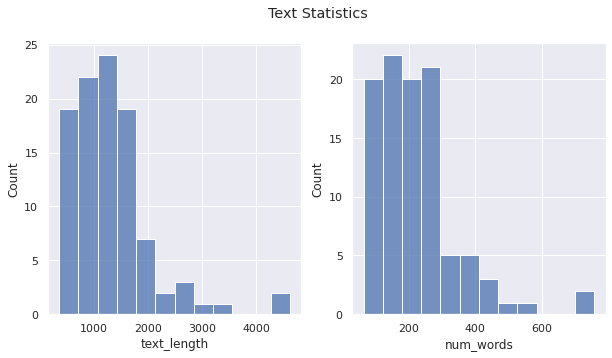

One of the most basic text analysis techniques is counting the frequency of words in the text. The following report shows the most common words in the text data, which can give us an idea of the overall topic and content of the text.



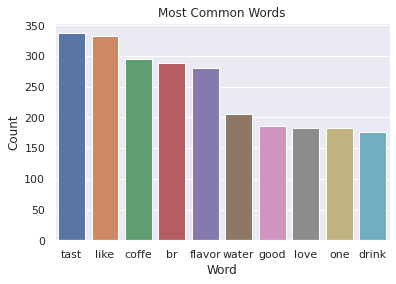

[('tast', 337), ('like', 333), ('coffe', 295), ('br', 288), ('flavor', 280), ('water', 205), ('good', 186), ('love', 182), ('one', 182), ('drink', 177)]
A word cloud is a visual representation of the most common words in a piece of text, where the size of each word corresponds to its frequency. The word cloud can help us quickly identify the main themes and topics in the text data.



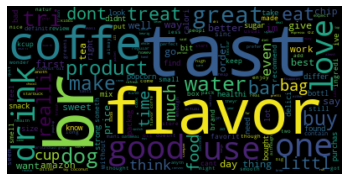

Sentiment analysis is a technique used to determine the emotional tone of a piece of text. The following report shows the sentiment of the text data and provides a breakdown of positive, negative, and neutral sentiments.

{'positive_count': 100, 'negative_count': 0, 'neutral_count': 0, 'positive_percent': 100.0, 'negative_percent': 0.0, 'neutral_percent': 0.0}


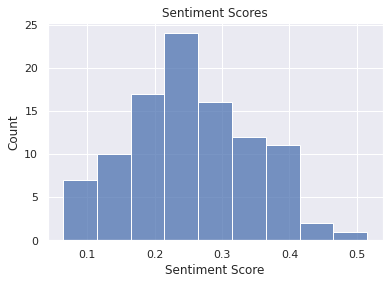

Corex is a topic modeling technique that helps identify latent topics in the text data. The following report shows the top topics extracted from the text data and provides a word cloud for each topic.

0: left, wast, corn, toss, pretti good, syrup, plastic bottl, favorit, use, problem
1: stir, chicken flavor, star, regular, empti, drop, especi, chili, feel, smell like
2: travel, set, homemad, jet fuel, guilt, avail, wait, butter, fast, spice
3: bought, benefit, love coconut, leav, soft, coupl, gobbl, good flavor, lot, friend
4: reorder, fact, espresso, bring, understand, afford, everi day, futur, pretti, sumatra
5: buy case, eat anyth, use cook, actual, healthier, turn, earli, exactli, stop, mile
6: larg, review, old, bud, candi, learn, timebr, plu, groceri, isnt
7: bed, someon, tend, flavor drink, expect, overpow, like drink, probabl, water tast, zuke
8: horribl, order, coconut tast, easi, aroma, thing like, decid, wow, replac, zuke mini
9: light, bake, floor, place, sick, hope, tast,

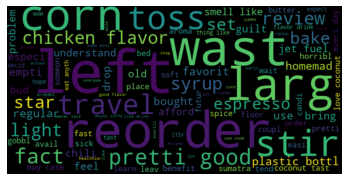

Extracting key sentences from a piece of text is a technique used to identify the most important or representative sentences in the text. The following report shows the top sentences for each topic of the text data.

Key sentences out of based on LSA algorithm: ['bought month old lab keep inhal dinner second flat purchas gift dog ownersbr br took dog day half figur toy first bark sinc frustrat could see smell kibbl couldnt get happi mistak paw watch us pull rope caught take minut eat cup kibbl insidebr br great featuresbr durabl easi wash nalgen type materialbr rope actual flexibl rubber stick make washingsanit easybr screwoff bottom make load toy simplebr transluc bottl see much kibbl leftbr hold sort size kibblebr br challeng featurebr sometim take tri get bottom screw back bc thread narrow bottom never fallen dog cant figur unscrew bottombr br tri treat ball past found couldnt hold enough kibbl keep activ go long treat ball product either big small dog kibbl make get food either way

In [65]:
df = merged_df[['Text']]
df.columns = ['text']

origin_df, df, train_embedding, test_embedding, best_model = run_tcap(
    data_spec=DataSpec(df=df, text_column='text'),
    feature_extraction = FeatureExtraction(split_data = False))

### Detect products with same functionality 

In [106]:
# collect product ID and original text 
embedding_origin = pd.concat([df_grouped[['ProductId','text1']].reset_index(), train_embedding.reset_index()], axis = 1)
embedding_origin = embedding_origin.rename(columns={'text1': 'text', 'ProductId':'target'})

In [107]:
# index: row index of the product we want to find similarities to 
# top similarities: # of similar products 

# All of the text you provided are reviews for the brand "Popchips" 
# and the reviews are generally positive, 
# praising the taste, crunch, and nutritional value of the chips
find_similar_texts(embedding_origin, index = 31, top_similarities=5)

Original text: after trying these chips for the first time I have reordered them several times. other who have tried at my home have ordered them . you won't regret buying them
Mixed reviews for this product. Some people liked it very much, some of them hated it. When i first tried it, they tasted horrible. But somehow I liked it when i had them the next time. Very light, flavored, spicy. The texture on the chips look good, but the after taste is not that great. That was my review. But a couple of my colleagues liked them so much that they had 2 bags of it at once. they loved the taste, flavor and also the after taste. 100 cal per bag with 0 cholesterol, not a bad bet!
A friend told me about the Pop Chips and how great they were, so I ordered a case of 3 different flavors to share at the office.  With only 100 calories per bag, they make a great mid-afternoon snack!
I just cannot understand the high praise these chips have received.  I ordered the variety pack and am very disappointed.

## Detect similar products based on summary
It works very well too!


In [82]:
df_grouped

,ProductId,text1,text2
0,B0007A0AQM,My maltipoo is pretty picky with food and trea...,Dog doesn't like them\nEXCELLENT !\nAWESOME!!!...
1,B0007A0AQW,I can't stand the smell of this treat. They a...,"Smells Aweful, but Jimmy Loves It\nGreat for T..."
2,B000BRR8VQ,Would pay 4 times more at the store for someth...,Super Deal\nMy puppy loves these\nPerfect for ...
3,B000CNB4LE,I am training for a marathon and was having tr...,Zico\nVery tasty\nGreat Hot Weather Drink\nWow...
4,B000ENUC3S,This Larabar tastes just like a cinnamon roll!...,Cinnamon Roll\nSo good\nHealthy Paleo/Raw/YUMM...
...,...,...,...
95,B008JKSJJ2,"KIND bar is little like fine dinning, they don...",Probably the best nutritional bar I've had thu...
96,B008JKTH2A,I think this bar is exceptional because it con...,Ki Almond Plus Cranberry and Almond Bars\nThe ...
97,B008JKTTUA,"These bars are exceptionally good, with whole ...",Kind Bars\nDelicious\nA new favorite for me!\n...
98,B008JKU2CO,"This is my favorite ""flacor"" of Kind bars. It ...",The perfect snack!\nKind Bars\nHighly recommen...


In [ ]:
df = merged_df[['Summary']]
df.columns = ['text']

origin_df, df, train_embedding, test_embedding, best_model = run_tcap(
    data_spec=DataSpec(df=df, text_column='text'),
    feature_extraction = FeatureExtraction(split_data = False))

In [109]:
# collect product ID and original text 
embedding_origin = pd.concat([merged_df[['ProductId','Summary']].reset_index(),\
                              train_embedding.reset_index()], axis = 1)
embedding_origin = embedding_origin.rename(columns={'Summary': 'text', 'ProductId':'target'})

In [ ]:
#All of the similar text and target combinations are referring to different \
# Zuke's dog treat products with different flavors and ingredients.
find_similar_texts(embedding_origin, index = 1, top_similarities=5)

In [ ]:
# These appear to be reviews for different types of bars, such as Larabars, 
# KIND bars, and other similar products. They all seem to be similar in that 
# they are marketed as healthy, tasty snacks, but they differ in terms of ingredients, flavor and nutritional values
find_similar_texts(embedding_origin, index = 1, top_similarities=20)

In [ ]:
# These appear to be similar products, all of them seem to be different types 
# of water or coconut water with different features
find_similar_texts(embedding_origin, index = 75, top_similarities=5)

In [117]:
# hey are all coffee products with different flavors.
find_similar_texts(embedding_origin, index = 99, top_similarities=5)

Original text: Keep fusing
Still too Dark  but Several of my friends liked it
A Fine Dessert Coffee
A better Starbucks coffee
no matter what I do, it still taste bad
Excellent Vanilla Flavored Coffee!
Met expectations, sadly.
Tasty, good vanilla flavor
good, not great, flavor
Very Strong!
Light on Vanilla
lovely coffee
Not to my taste
No Artificial Flavors and it's so delish!
Packs A Punch
Nice Subtle Vanilla Flavor
Starbucks Fusions Vanilla
YUM!!
Subtle, not over-powering vanilla flavored coffee that's smooth and delicious
Better coffees out there, not much vanilla flavor
Original target: B0090X8IPM

Similar text: Keep fusing
Still too Dark  but Several of my friends liked it
A Fine Dessert Coffee
A better Starbucks coffee
no matter what I do, it still taste bad
Excellent Vanilla Flavored Coffee!
Met expectations, sadly.
Tasty, good vanilla flavor
good, not great, flavor
Very Strong!
Light on Vanilla
lovely coffee
Not to my taste
No Artificial Flavors and it's so delish!
Packs A Punch